# Import libraries, create document class to hold info

In [1]:
#  /Data/celebs-usa/female contains 381 texts by females
#  /Data/celebs-usa/male contains 912 texts by males
#  /Data/celebs-other-json contains text by

# Identify birth year as that is a constant, these tweets are from 2011-2018, age range constantly changes but birth year stays constant
# using birth year, predict age 10-15, 15-20, 20-25, 25-30, 30-35, 35-40, 45-55,55+  
#{'25-34', '35-44', '45-54', '55-64', '65+'}

from os import listdir, makedirs
from os.path import isfile, join, splitext, split
import json
from collections import Counter
import ftfy
import re
import nltk
import copy
from collections import Counter
import seaborn as sns
import pandas as pd
import numpy as np
import ndjson
import pickle
import os
import jsonlines

        
hashtag_re = re.compile(r"#\w+")
mention_re = re.compile(r"@\w+")
url_re = re.compile(r"(?:https?://)?(?:[-\w]+\.)+[a-zA-Z]{2,9}[-\w/#~:;.?+=&%@~]*")

def preprocess(text):
    p_text = hashtag_re.sub("[hashtag]",text)
    p_text = mention_re.sub("[mention]",p_text)
    p_text = url_re.sub("[url]",p_text)
    p_text = ftfy.fix_text(p_text)
    return p_text.lower()

tokenise_re = re.compile(r"(\[[^\]]+\]|[-'\w]+|[^\s\w\[']+)") #([]|words|other non-space)
def tokenise(text):
    return tokenise_re.findall(text)

        
class Document:
    def __init__(self, meta={}):
        self.meta = meta
        self.tokens_fql = Counter() #empty Counter, ready to be added to with Counter.update.
        self.pos_fql = Counter()
        self.pos_list = [] #empty list for pos tags from running text.
        self.num_tokens = 0
        
    def extract_features_from_text(self, text):
        p_text = preprocess(text)
        tokens = tokenise(p_text)
        self.num_tokens += len(tokens)
        self.tokens_fql.update(tokens) #updating Counter counts items in list, adding to existing Counter items.
        pos_tagged = nltk.pos_tag(tokens)
        pos = [tag[1] for tag in pos_tagged]
        self.pos_fql.update(pos)
        self.pos_list.extend(pos)
        
    def extract_features_from_texts(self, texts): #texts should be iterable text lines, e.g. read in from file.
        for text in texts:
            extract_features_from_text(text)
            
    def average_token_length(self):
        sum_lengths = 0
        for key, value in self.tokens_fql.items():
            sum_lengths += len(key) * value
        return sum_lengths / self.num_tokens

# Reading in Celebrity Data, converting to Document Class and saving to pickle file

In [3]:
'''
This gets the celebrity data and adds the correct gender and ages 
to each json object with text
'''
def getCelebData():
    path = '/home/jay/Downloads/pan19-celebrity-profiling-training-dataset-2019-01-31/feeds.ndjson'
    path2 = '/home/jay/Downloads/pan19-celebrity-profiling-training-dataset-2019-01-31/labels.ndjson'

    # Read in the twitter text
    data = []
    with jsonlines.open(path) as reader:
        for obj in reader:
            obj['test']='lol'
            data.append(obj)
            if len(data) >2999:
                break;
    # Here the correct labels are identified and paried           
    labels = []
    with jsonlines.open(path2) as reader:
        for obj in reader:
            for d in data:
                if d['id'] == obj['id']:
                    d['gender'] = obj['gender']
                    d['birthyear'] = obj['birthyear']
    return data

'''
This function returns the 5 year group a year of birth resides in, e.g. 1995 is between 1995-1999 (inclusive 5 year period)
'''
def getYearRange(yearOfBirth):
    YearGroupGap = 5
    for minYear in range(1900,2015,YearGroupGap):
        maxYear = minYear+YearGroupGap
        #print('min: ',minYear,'max: ',maxYear)
        if (yearOfBirth >= minYear) and (yearOfBirth < maxYear):
            return( str(minYear)+'-'+str(maxYear-1) )
    raise Exception('year of Birth passed in - ' + str(yearOfBirth)+' is not in range of min and max years' ) 
    

'''
This helper function uses the Document class to return a doc
class for each user with the correct gender, age and tweets
'''
def getDocument(data):
    gender    = data['gender']
    birthyear = data['birthyear']
    if data['birthyear'] != 'unknown':
        birthYearRange = getYearRange(data['birthyear'])

    doc = Document({'gender': gender, 'birthyear':birthyear, 'birthyearrange':birthYearRange}) #include metadata
    for tweet in data['text']:
        doc.extract_features_from_text(tweet)
    return doc

'''
Check if the pickle file exists, if not then create it, else read in
'''
corpus = []
if os.path.exists("/home/jay/Documents/AppliedDataMining/FinalProject/Data/CelebFile"):
    with open('/home/jay/Documents/AppliedDataMining/FinalProject/Data/CelebFile', 'rb') as fp:
        corpus = pickle.load(fp)
    print('CELEB FILE EXISTS')
else:
    print('CELEB FILE DOES NOT EXISTS, CREATING')
    # Call the function to get the twitter data
    corpus = getCelebData()
    #For each json object, convert it to a document object
    for i in range(len(corpus)):
        print('Doing Obj Number: ',i)
        corpus[i] = getDocument(corpus[i])
    
    with open('/home/jay/Documents/AppliedDataMining/FinalProject/Data/CelebFile', 'wb') as fp:
        pickle.dump(corpus, fp)
    print('CELEB FILE CREATED')

CELEB FILE EXISTS


# Exploratory Data Analysis

got here


/home/jay/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


KeyError: 'birth_year_range'

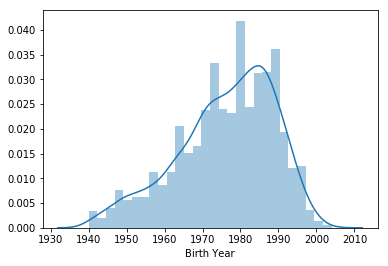

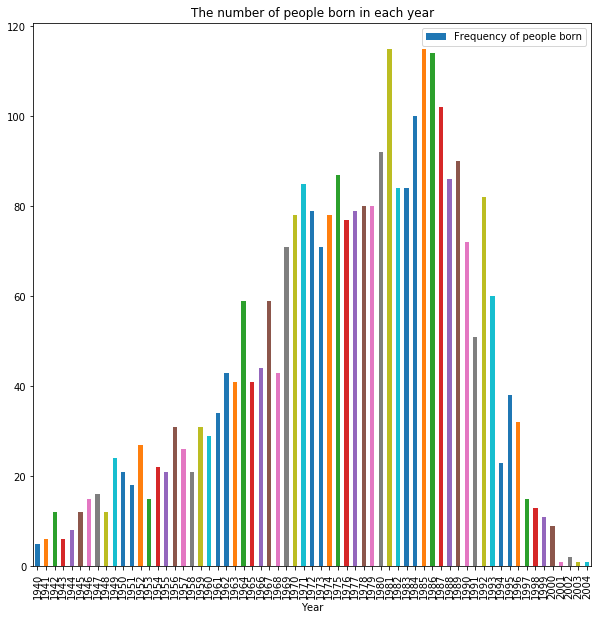

In [4]:
birthCorpus = copy.deepcopy(corpus)

for doc in birthCorpus:
    if doc.meta['birthyear'] != 'unknown':
        birthYearRange = getYearRange(doc.meta['birthyear'])
        doc.meta['birth_year_range'] = birthYearRange
#############Eventually remove above after next data read (this will be done when data read in)
print('got here')

#Get all the birth years and plot a histogram
birth_year_y = [d.meta['birthyear'] for d in corpus]
x = pd.Series(birth_year_y, name="Birth Year")
sns.distplot(x)

#Get a count of of the birth years and plot a bar chart
df = pd.DataFrame.from_dict(Counter(birth_year_y), orient='index').reset_index()
df.columns = ['Year','Frequency of people born']
df = df.sort_values(by=['Year'])
df.plot.bar(x='Year', y='Frequency of people born', rot=90,figsize=(10,10), title='The number of people born in each year')
df

#Get all the birth years and plot a histogram
birth_year_range_y = [d.meta['birth_year_range'] for d in corpus]
x = pd.Series(birth_year_range_y, name="Birth Year Range")
sns.distplot(x)

#Get all the genders and plot a bar chart
gender_y = [d.meta['gender'] for d in corpus]
x = pd.Series(gender_y, name="Gender")
sns.distplot(x)

print('d')

In [ ]:
min(birth_year_y)  #1932
max(birth_year_y)  #1993

genderCorpus = [d for d in corpus if d.meta['gender'] != 'unknown']
gender_y = [d.meta['gender'] for d in genderCorpus]
gender_X = genderCorpus
GenderCount = Counter(gender_y)

birthCorpus = [d for d in corpus if d.meta['birthyear'] != 'unknown']
birth_year_y = [d.meta['birthyear'] for d in birthCorpus]
birth_year_X = corpus
BirthYearCount = Counter(birth_year_y)

print(GenderCount)
print('---------------')
print(BirthYearCount)


birth_year_y = [d.meta['gender'] for d in corpus]
print('doing')
Counter(birth_year_y)

In [ ]:
birth_year_y = [d.meta['birthyear'] for d in corpus]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 0, stratify=y)